In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [1]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

%matplotlib inline

from keras_ssd7 import build_model
from keras_ssd300 import ssd_300
from keras_ssd_loss import SSDLoss
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2
from ssd_batch_generator import BatchGenerator

Using TensorFlow backend.


ModuleNotFoundError: No module named 'keras_ssd7'

In [3]:
from ssd_keras.keras_ssd7 import build_model
from ssd_keras.keras_ssd_loss import SSDLoss
from ssd_keras.ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2
from ssd_keras.ssd_batch_generator import BatchGenerator

In [4]:
from tensorflow.python.client import device_lib

In [5]:
device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17128412608041213887, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 5944442880
 locality {
   bus_id: 1
 }
 incarnation: 13048351652414937701
 physical_device_desc: "device: 0, name: GeForce GTX 980 Ti, pci bus id: 0000:02:00.0"]

### 1. Introduction and building the model

The cell below sets a number of parameters that define the model architecture and then calls the function `build_model()` to build the model. Read the comments and the documentation, but here are some further explanations for a few parameters:

* Set the height, width, and number of color channels to whatever you want the model to accept as image input. This does not have to be the actual size of your input images! However, if your input images have a different size than you define as the model input here, you must use the `crop`, `resize` and/or `random_crop` features of the batch generator to convert your images to the model input size during training. If your dataset contains images of varying size, like the Pascal VOC datasets for example, use the `random_crop` feature of the batch generator to cope with that (see the documentation).
* The number of classes includes the background class, i.e. if you have `n` positive classes in your dataset, set `n_classes = n + 1`. Class ID 0 must always be reserved for the background class, i.e. your positive classes must have positive integers as IDs.
* The reason why the list of scaling factors has 5 elements even though there are only 4 predictor layers in this model is that the last scaling factor is used for the second aspect-ratio-1 box of the last predictor layer. See the documentation for details.
* Alternatively to passing an explicit list of scaling factors, you could also just define a mimimum and a maximum scale, in which case the other scaling factors would be linearly interpolated. If you pass both min/max scaling factors and an explicit list, the explicit list will be used.
* `build_model()` and `SSDBoxEncoder` have two arguments for the anchor box aspect ratios: `aspect_ratios_global` and `aspect_ratios_per_layer`. You can use either of the two. If you use `aspect_ratios_global`, then you just pass a list containing all aspect ratios for which you would like to create anchor boxes. Every aspect ratio you want to include must be listed once and only once. If you use `aspect_ratios_per_layer`, then you pass a list containing lists of aspect ratios for each individual predictor layer. In the example below, the model has four predictor layers, so you would pass a list containing four lists.
* If `two_boxes_for_ar1 == True`, then two boxes of different size will be created for aspect ratio 1 for each predictor layer. See the documentation for details.
* If `limit_boxes == True`, then the generated anchor boxes will be limited so that they lie entirely within the image boundaries. This feature is called 'clip' in the original Caffe implementation. Even though it may seem counterintuitive, it is recommended **not** to clip the anchor boxes. According to Wei Liu, the model performs slightly better when the anchors are not clipped.
* The variances are scaling factors for the target coordinates. Leaving them at 1.0 for each of the four box coordinates means that they have no effect whatsoever. Decreasing them to below 1.0 **upscales** the gradient for the respective target box coordinate.
* The `coords` argument lets you choose what coordinate format the model should learn. If you choose the 'centroids' format, the targets will be converted to the (cx, cy, w, h) coordinate format used in the original implementation. If you choose the 'minmax' format, the targets will be converted to the coordinate format (xmin, xmax, ymin, ymax). The model, of course, will learn whatever the targets tell it to.
* `normalize_coords` converts all absolute ground truth and anchor box coordinates to relative coordinates, i.e. to coordinates that lie within [0,1] relative to the image height and width. Whether you use absolute or relative coordinates has no effect on the training - the targets end up being the same in both cases. The main reason why the original implementation uses relative coordinates is because it makes coding some box operations more convenient. This defaults to `False`.

These paramters might be a bit much at first, but they allow you to configure many things easily.

The parameters set below are not only needed to build the model, but are also passed to the `SSDBoxEncoder` constructor in the subsequent cell, which is responsible for matching and encoding ground truth boxes and anchor boxes during training. In order to do that, it needs to know the anchor box specifications. It is for the same reason that `build_model()` does not only return the model itself, but also `predictor_sizes`, a list of the spatial sizes of the convolutional predictor layers - `SSDBoxEncoder` needs this information to know where the anchor boxes must be placed spatially.

The original Caffe implementation does pretty much everything inside a model layer: The ground truth boxes are matched and encoded inside [MultiBoxLossLayer](https://github.com/weiliu89/caffe/blob/ssd/src/caffe/layers/multibox_loss_layer.cpp), and box decoding, confidence thresholding and non-maximum suppression is performed in [DetectionOutputLayer](https://github.com/weiliu89/caffe/blob/ssd/src/caffe/layers/detection_output_layer.cpp). In contrast to that, in the current form of this implementation, ground truth box matching and encoding happens as part of the mini batch generation (i.e. outside of the model itself). To be specific, the `generate()` method of `BatchGenerator` calls the `encode_y()` method of `SSDBoxEncoder` to encode the ground truth labels, and then yields the matched and encoded target tensor to be passed to the loss function. Similarly, the model here outputs the raw prediction tensor. The decoding, confidence thresholding, and non-maximum suppression (NMS) is then performed by `decode_y2()`, i.e. also outside the model. It's (almost) the same process as in the original Caffe implmentation, it's just that the code is organized differently here, which likely has performance implications, but I haven't measured it yet. I might look into incorporating all processing steps inside the model itself, but for now it was just easier to take the non-learning-relevant steps outside of Keras/Tensorflow. This is one advantage of Caffe: It's more convenient to write complex custom layers in plain C++ than to grapple with the Keras/Tensorflow API.

### Note:

The example setup below was used to train SSD7 on two street traffic datasets released by [Udacity](https://github.com/udacity/self-driving-car/tree/master/annotations) with around 20,000 images in total and 5 object classes (car, truck, pedestrian, bicyclist, traffic light), although the vast majority of the objects are cars. The original datasets have a constant image size of 1200x1920 RGB. I consolidated the two datasets, removed a few bad samples (although there are probably many more), and resized the images to 300x480 RGB, i.e. to one sixteenth of the original image size. In case you'd like to train a model on the same dataset, you can find the consolidated and resized dataset I used [here](https://drive.google.com/file/d/0B0WbA4IemlxlT1IzQ0U1S2xHYVU/view?usp=sharing).

In [6]:
### Set up the model

# 1: Set some necessary parameters

img_height = 224 # Height of the input images
img_width = 224 # Width of the input images
img_channels = 1 # Number of color channels of the input images
n_classes = 2 # Number of classes including the background class

min_scale = 0.08 # The scaling factor for the smallest anchor boxe
max_scale = 0.96 # The scaling factor for the largest anchor boxes
scales = [0.08, 0.16, 0.32, 0.64, 0.96]

#min_scale = 0.05 # The scaling factor for the smallest anchor boxes
#max_scale = 0.50 # The scaling factor for the largest anchor boxes
#scales = None #[0.08, 0.16, 0.32, 0.64, 0.96] # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
aspect_ratios = [1.0]  #[0.5, 1.0, 2.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = False # Whether or not you want to generate two anchor boxes for aspect ratio 1
limit_boxes = True # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
coords = 'centroids' # Whether the box coordinates to be used 8should be in the 'centroids' or 'minmax' format, see documentation
normalize_coords = False # Whether or not the model is supposed to use relative coordinates that are within [0,1]

# 2: Build the Keras model (and possibly load some trained weights)

K.clear_session() # Clear previous models from memory.
# The output `predictor_sizes` is needed below to set up `SSDBoxEncoder`
model, predictor_sizes = build_model(image_size=(img_height, img_width, img_channels),
#model, predictor_sizes = ssd_300(image_size=(img_height, img_width, img_channels),
                                      n_classes=n_classes,
                                      min_scale=min_scale,
                                      max_scale=max_scale,
                                      scales=scales,
                                      aspect_ratios_global=aspect_ratios,
                                      aspect_ratios_per_layer=None,
                                      two_boxes_for_ar1=two_boxes_for_ar1,
                                      limit_boxes=limit_boxes,
                                      variances=variances,
                                      coords=coords,
                                      normalize_coords=normalize_coords)
#model.load_weights('./ssd7_0_weights.h5')
#model = load_model('./ssd7_0.h5')

### 2. Set up the training

The cell below sets up everything necessary to train the model. The only things you have to set are the correct file paths to the images and labels in your dataset, and in case your labels do not come in a CSV file, you might have to switch from the CSV parser to the XML parser or you might have to write a new parser method in the `BatchGenerator` class that can handle whatever the format of your labels is. The README of this project provides an overview of the design of the batch generator class, which should help you in case you need to write a new parser or adapt one of the existing parsers to your needs.

For everything in this cell that does not concern loading your data: You don't have to change anything (but you can change everything of course).

Set the batch size to whatever value you like (and one that makes the model fit inside your GPU memory), it's not the most important hyperparameter - 32 works well, but so do most other batch sizes.

I'm using an Adam optimizer with the standard initial learning rate of 0.001 and a small decay, nothing special.

`SSDLoss` is a custom Keras loss function that implements the multi-task log loss for classification and smooth L1 loss for localization. `neg_pos_ratio` and `alpha` are set as in the paper and `n_neg_min` is a rather unimportant optional parameter to make sure that a certain number of negative boxes always enters the loss function even if there are very few or no positive boxes in a batch, which should never happen anyway.

The `ssd_box_encoder` object, which, as explained above, knows how to match and encode the ground truth labels into the format that the model needs, is passed to the batch generator, which during training loads the next batch of images and labels, optionally performs data augmentation, and encodes the ground truth labels.

There are two parameters in the SSDBoxEncoder that you should note: `pos_iou_threshold` and `neg_iou_threshold`. The former determines the minimum Jaccard overlap between a ground truth box and an anchor box for a match and is set to 0.5, the value stated in the paper. The latter, `neg_iou_threshold`, is not in the paper, but it is useful to improve the learning process. It determines the maximum allowed Jaccard overlap between an anchor box and any ground truth box in order for that anchor box to be considered a negative box. This is useful because you want a clear margin between negative and positive boxes. An anchor box that almost contains an object should not be forced to learn to predict a negative box in such a case. 0.2 is a reasonable value that is used by various other object detection models.

In [7]:
### Set up training

batch_size = 32

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-05)

ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

# 4: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function 

ssd_box_encoder = SSDBoxEncoder(img_height=img_height,
                                img_width=img_width,
                                n_classes=n_classes, 
                                predictor_sizes=predictor_sizes,
                                min_scale=min_scale,
                                max_scale=max_scale,
                                scales=scales,
                                aspect_ratios_global=aspect_ratios,
                                aspect_ratios_per_layer=None,
                                two_boxes_for_ar1=two_boxes_for_ar1,
                                limit_boxes=limit_boxes,
                                variances=variances,
                                pos_iou_threshold=0.5,
                                neg_iou_threshold=0.2,
                                coords=coords,
                                normalize_coords=normalize_coords)

Train only on patches with at least one crater:

In [8]:
labels = pd.read_csv("../../../mars_craters-kit/data/labels_train.csv")

In [9]:
patches = np.unique(labels['i'])

In [10]:
len(patches)

4947

In [12]:
# 5: Create the training set batch generator

train_dataset = BatchGenerator(images_path="../../../mars_craters-kit/data/data_train.npy",
                               range_=patches[:1000].tolist(),
                               include_classes='all',
                               box_output_format=['class_id', 'xmin', 'xmax', 'ymin', 'ymax']) # This is the format in which the generator is supposed to output the labels. At the moment it **must** be the format set here.

train_dataset.parse_csv(labels_path='../../../mars_craters-kit/data/labels_train.csv',
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id']) # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.

# Change the online data augmentation settings as you like
train_generator = train_dataset.generate(batch_size=batch_size,
                                         train=True,
                                         ssd_box_encoder=ssd_box_encoder,
                                         equalize=False,
                                         #brightness=(0.5, 2, 0.5), # Randomly change brightness between 0.5 and 2 with probability 0.5
                                         brightness=False,
                                         #flip=0.5, # Randomly flip horizontally with probability 0.5
                                         flip=False,
                                         #translate=((5, 50), (3, 30), 0.5), # Randomly translate by 5-50 pixels horizontally and 3-30 pixels vertically with probability 0.5
                                         translate=False,
                                         #scale=(0.75, 1.3, 0.5), # Randomly scale between 0.75 and 1.3 with probability 0.5
                                         scale=False,
                                         random_crop=False,
                                         crop=False,
                                         resize=False,
                                         gray=False,
                                         limit_boxes=True,
                                         include_thresh=0.4,
                                         diagnostics=False)

n_train_samples = train_dataset.get_n_samples()

In [13]:
# 6: Create the validation set batch generator (if you want to use a validation dataset)

val_dataset = BatchGenerator(images_path="../../../mars_craters-kit/data/data_train.npy",
                             range_=patches[1000:1300].tolist(),
                             include_classes='all',
                             box_output_format=['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])

val_dataset.parse_csv(labels_path='../../../mars_craters-kit/data/labels_train.csv',
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'])

val_generator = val_dataset.generate(batch_size=batch_size,
                                     train=True,
                                     ssd_box_encoder=ssd_box_encoder,
                                     equalize=False,
                                     brightness=False,
                                     flip=False,
                                     translate=False,
                                     scale=False,
                                     random_crop=False,
                                     crop=False,
                                     resize=False,
                                     gray=False,
                                     limit_boxes=True,
                                     include_thresh=0.4,
                                     diagnostics=False)

n_val_samples = val_dataset.get_n_samples()

In [13]:
class BatchGeneratorBuilder(object):
    """A batch generator builder for generating batches of images on the fly.

    This class is a way to build training and
    validation generators that yield each time a tuple (X, y) of mini-batches.
    The generators are built in a way to fit into keras API of `fit_generator`
    (see https://keras.io/models/model/).

    The fit function from `Classifier` should then use the instance
    to build train and validation generators, using the method
    `get_train_valid_generators`

    Parameters
    ==========

    X_array : ArrayContainer of int
        vector of image data to train on
    y_array : vector of int
        vector of object labels corresponding to `X_array`

    """

    def __init__(self, X_array, y_array):
        self.X_array = X_array
        self.y_array = y_array
        self.nb_examples = len(X_array)

    def get_train_valid_generators(self, batch_size=256, valid_ratio=0.1):
        """Build train and valid generators for keras.

        This method is used by the user defined `Classifier` to o build train
        and valid generators that will be used in keras `fit_generator`.

        Parameters
        ==========

        batch_size : int
            size of mini-batches
        valid_ratio : float between 0 and 1
            ratio of validation data

        Returns
        =======

        a 4-tuple (gen_train, gen_valid, nb_train, nb_valid) where:
            - gen_train is a generator function for training data
            - gen_valid is a generator function for valid data
            - nb_train is the number of training examples
            - nb_valid is the number of validation examples
        The number of training and validation data are necessary
        so that we can use the keras method `fit_generator`.
        """
        nb_valid = int(valid_ratio * self.nb_examples)
        nb_train = self.nb_examples - nb_valid
        indices = np.arange(self.nb_examples)
        train_indices = indices[0:nb_train]
        valid_indices = indices[nb_train:]
        gen_train = self._get_generator(
            indices=train_indices, batch_size=batch_size)
        gen_valid = self._get_generator(
            indices=valid_indices, batch_size=batch_size)
        return gen_train, gen_valid, nb_train, nb_valid
    
    def _get_generator(self, indices=None, batch_size=256):
        if indices is None:
            indices = np.arange(self.nb_examples)
        # Infinite loop, as required by keras `fit_generator`.
        # However, as we provide the number of examples per epoch
        # and the user specifies the total number of epochs, it will
        # be able to end.
        while True:
            X = self.X_array[indices]
            y = [self.y_array[i] for i in indices]

            # converting to float needed?
            # X = np.array(X, dtype='float32')

            # Yielding mini-batches
            for i in range(0, len(X), batch_size):
                X_batch = [np.expand_dims(img, -1) for img in X[i:i + batch_size]]
                y_batch = y[i:i + batch_size]
                
                #y_batch = [np.array([(1, cx, cy, 2*r, 2*r) for (cx, cy, r) in y_patch]) for y_patch in y_batch]
                y_batch = [np.array([(1, cx -r, cy -r, cx + r, cy +r) for (cy, cx, r) in y_patch]) for y_patch in y_batch]
                
                y_batch_encoded = ssd_box_encoder.encode_y(y_batch)
                
                yield np.array(X_batch), y_batch_encoded
                

In [14]:
import sys
sys.path.append('../../../mars_craters-kit/')

In [59]:
from problem import get_train_data

In [60]:
X, y = get_train_data('../../../mars_craters-kit/')

In [61]:
X.shape

(10000, 224, 224)

In [62]:
train_dataset = BatchGeneratorBuilder(X[:6666], y[:6666])

In [63]:
train_generator, val_generator, n_train_samples, n_val_samples = train_dataset.get_train_valid_generators(batch_size=batch_size)

### 3. Run the training

Now that everything is set up, we're ready to start training. Set the number of epochs and the model name, the weights name in `ModelCheckpoint` and the filepaths to wherever you'd like to save the model. There isn't much more to say here, just execute the cell. If you get "out of memory" errors during training, reduce the batch size.

Training currently only monitors the validation loss, not the mAP.

In [23]:
X, y = next(train_generator)

In [ ]:
X

In [24]:
X.shape

(32, 224, 224, 1)

In [14]:
len(y)

32

In [15]:
y.shape

(32, 1049, 14)

In [16]:
y[0][0]

array([ 1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  4.8,  4.8,  9.6,  9.6,  1. ,
        1. ,  1. ,  1. ])

In [17]:
y[0][10]

array([  1. ,   0. ,   0. ,   0. ,   0. ,   0. ,  84. ,   4.8,  11.2,
         9.6,   1. ,   1. ,   1. ,   1. ])

In [ ]:
np.save('y_good.npy')

In [13]:
model.load_weights("ssd7_test_weights.h5")

In [ ]:
### Run training

# 6: Run training

epochs = 50

history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = ceil(n_train_samples/batch_size),
                              epochs = epochs,
                              callbacks = [ModelCheckpoint('./ssd7_0_weights_epoch{epoch:02d}_loss{loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1),
                                           EarlyStopping(monitor='val_loss',
                                                         min_delta=0.001,
                                                         patience=5),
                                           ReduceLROnPlateau(monitor='val_loss',
                                                             factor=0.5,
                                                             patience=0,
                                                             epsilon=0.001,
                                                             cooldown=0)],
                              validation_data = val_generator,
                              validation_steps = ceil(n_val_samples/batch_size))

Epoch 1/50
188/188 [==============================] - 27s - loss: 0.0867 - val_loss: 0.0895
Epoch 2/50
188/188 [==============================] - 27s - loss: 0.0841 - val_loss: 0.0874
Epoch 3/50
188/188 [==============================] - 27s - loss: 0.0825 - val_loss: 0.0861
Epoch 4/50
188/188 [==============================] - 27s - loss: 0.0815 - val_loss: 0.0853
Epoch 5/50
188/188 [==============================] - 28s - loss: 0.0805 - val_loss: 0.0842
Epoch 6/50
188/188 [==============================] - 28s - loss: 0.0801 - val_loss: 0.0838
Epoch 7/50
140/188 [=====================>........] - ETA: 6s - loss: 0.0791

In [58]:
model_name = 'ssd7_test'
model.save('./{}.h5'.format(model_name))
model.save_weights('./{}_weights.h5'.format(model_name))

print()
print("Model saved as {}.h5".format(model_name))
print("Weights also saved separately as {}_weights.h5".format(model_name))
print()


Model saved as ssd7_test.h5
Weights also saved separately as ssd7_test_weights.h5



In [22]:
def _read_data(path, typ):
    """
    Read and process data and labels

    Parameters
    ----------
    path : path to directory that has 'data' subdir
    typ : {'train', 'test'}

    Returns
    -------
    X, y data

    """
    try:
        data_path = os.path.join(path, 'data', 'data_{}.npy'.format(typ))
        src = np.load(data_path, mmap_mode='r')

        labels_path = os.path.join(path, 'data', 'labels_{}.csv'.format(typ))
        labels = pd.read_csv(labels_path)
    except IOError:
        raise IOError("'data/data_{}.npy' and 'data/labels_{}.csv' are not "
                      "found. Ensure you ran 'python download_data.py' to "
                      "obtain the train/test data".format(typ))

    # convert the dataframe with crater positions to list of
    # list of (x, y, radius) tuples (list of arrays of shape (n, 3) with n
    # true craters on an image

    # determine locations of craters for each patch in the labels array
    n_true_patches = labels.groupby('i').size().reindex(
        range(src.shape[0]), fill_value=0).values
    # make cumulative sum to obtain start/stop to slice the labels
    n_cum = np.array(n_true_patches).cumsum()
    n_cum = np.insert(n_cum, 0, 0)

    labels_array = labels[['row_p', 'col_p', 'radius_p']].values
    y = [[tuple(x) for x in labels_array[i:j]]
         for i, j in zip(n_cum[:-1], n_cum[1:])]
    # convert list to object array of lists
    y_array = np.empty(len(y), dtype=object)
    y_array[:] = y

    test = os.getenv('RAMP_TEST_MODE', 0)

    if test:
        # return src, y
        return src[:30], y_array[:30]
    else:
        return src, y_array

In [23]:
X_test, y_test = _read_data('../../../mars_craters-kit/', 'test')

In [24]:
y_pred = model.predict(np.expand_dims(X_test[:500], -1))

In [25]:
y_pred.shape

(500, 846, 14)

In [26]:
y_pred[0][:, :2]

array([[ 0.84142345,  0.15857659],
       [ 0.82689178,  0.17310819],
       [ 0.81978643,  0.18021359],
       ..., 
       [ 0.80010444,  0.19989553],
       [ 0.79437906,  0.20562091],
       [ 0.78197044,  0.21802959]], dtype=float32)

In [27]:
y_pred_decoded = decode_y(y_pred, confidence_thresh=0.01, input_coords='centroids')

In [28]:
y_pred_decoded[0][:, 1]

array([ 0.17709713,  0.17739184,  0.17829888,  0.17823724,  0.17724313,
        0.17756718,  0.1782138 ,  0.17847304,  0.17917073,  0.17900665,
        0.17880169,  0.17977194,  0.17939742,  0.17863852,  0.17978166,
        0.17975879,  0.18008123,  0.18075475,  0.18121767,  0.18061842,
        0.18024164,  0.18118511,  0.18035887,  0.18008967,  0.18013646,
        0.1821449 ,  0.1821788 ,  0.18231404,  0.18172148,  0.18227811,
        0.18193406,  0.18095078,  0.18225121,  0.18226628,  0.18021359,
        0.18228711,  0.1824047 ,  0.18252155,  0.18253629,  0.18262178,
        0.18345501,  0.18302375,  0.18303211,  0.18323319,  0.18901487,
        0.18342045,  0.18376042,  0.18437603,  0.18782552,  0.18729779,
        0.18389663,  0.18396968,  0.18451415,  0.18485679,  0.18486047,
        0.18726531,  0.18529756,  0.18569162,  0.18552496,  0.18527919,
        0.18553355,  0.18564382,  0.18604761,  0.18623441,  0.18656793,
        0.18714413,  0.1872687 ,  0.18985303,  0.18506823,  0.18

In [29]:
def get_xyr2(boxes, pred=True):
    res = []
    for box in boxes:
        if pred:
            box = box[1:]
        r = (((box[2]-box[1]) + (box[4]-box[3])) /2) / 2
        x = box[1] + (box[2] - box[1])/2
        y = box[3] + (box[4] - box[3])/2
        conf = box[0]
        if pred:
            res.append((conf, x, y, r))
        else:
            res.append((x, y, r))
    return res

In [30]:
def get_xyr3(boxes, pred=True):
    res = []
    for box in boxes:
        if pred:
            box = box[1:]
        r = (((box[2]-box[1]) + (box[4]-box[3])) /2) / 2
        x = box[1] + (box[2] - box[1])/2
        y = box[3] + (box[4] - box[3])/2
        conf = box[0]
        if pred:
            res.append((conf, y, x, r))
        else:
            res.append((x, y, r))
    return res

In [31]:
y_pred2 = [get_xyr2(x, pred=True) for x in y_pred_decoded]

In [32]:
y_pred3 = [get_xyr3(x, pred=True) for x in y_pred_decoded]

In [33]:
import rampwf

In [34]:
precision = rampwf.score_types.DetectionPrecision(iou_threshold=0.00001, conf_threshold=0.25)

In [35]:
average_precision = rampwf.score_types.AverageDetectionPrecision(iou_threshold=0.01)

In [30]:
average_precision(y_test, y_pred2)

/home/joris/ramp-workflow/rampwf/score_types/detection.py:449: RuntimeWarning: invalid value encountered in long_scalars
  return n_pred_correct / n_pred_all


0.054517973427212867

In [38]:
precision(y_test, y_pred2, conf_threshold=0.25)

0.085918854415274457

In [39]:
precision(y_test, y_pred3, conf_threshold=0.25)

0.21718377088305491

In [90]:
y_pred2[0][:3]

[(0.16140586137771606,
  37.286956787109375,
  204.69013977050781,
  8.1024932861328125),
 (0.16149838268756866,
  27.013156890869141,
  201.11296081542969,
  20.164506912231445),
 (0.16170215606689453,
  20.467216491699219,
  179.36500549316406,
  15.128203392028809)]

In [91]:
y_pred3[0][:3]

[(0.16140586137771606,
  204.69013977050781,
  37.286956787109375,
  8.1024932861328125),
 (0.16149838268756866,
  201.11296081542969,
  27.013156890869141,
  20.164506912231445),
 (0.16170215606689453,
  179.36500549316406,
  20.467216491699219,
  15.128203392028809)]

In [57]:
i = 8

(174.0, 202.0, 9.25)
(211.0, 27.0, 7.3499999999999996)


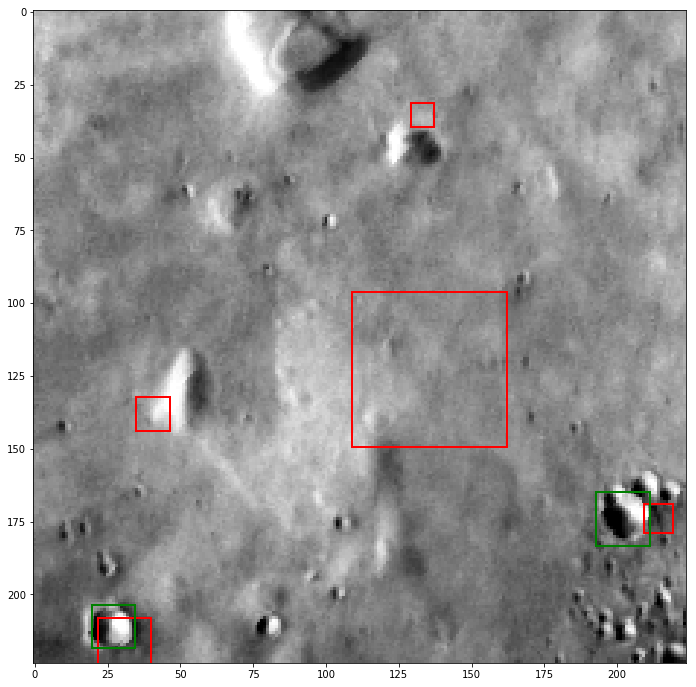

In [58]:
# 5: Draw the predicted boxes onto the image

fig, ax = plt.subplots(figsize=(20,12))
ax.imshow(X_test[i], cmap=plt.cm.gray)

classes = ['background', 'car', 'truck', 'pedestrian', 'bicyclist', 'light'] # Just so we can print class names onto the image instead of IDs

# Draw the predicted boxes in blue
#for box in np.sort(y_pred_decoded, axis=0)[-5:]:#[i]:
#for box in y_pred_decoded:#[i]
for box in y_pred3[i][-5:]:#[i]

    #label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    # current_axis.add_patch(plt.Rectangle((box[2], box[4]), box[3]-box[2], box[5]-box[4], color='blue', fill=False, linewidth=2))  
    #ax.add_patch(plt.Rectangle((box[4], box[2]), box[5]-box[4], box[3]-box[2], color='blue', fill=False, linewidth=2))  
    #current_axis.text(box[2], box[4], label, size='x-large', color='white', bbox={'facecolor':'blue', 'alpha':1.0})
    ax.add_patch(plt.Rectangle((box[2]-box[3], box[1]-box[3]), box[3]*2, box[3]*2, color='red', fill=False, linewidth=2))  

# Draw the ground truth boxes in green (omit the label for more clarity)
for box in y_test[i]:
    print(box)
    #label = '{}'.format(classes[int(box[0])])
    ax.add_patch(plt.Rectangle((box[1]-box[2], box[0]-box[2]), box[2]*2, box[2]*2, color='green', fill=False, linewidth=2))  
    #current_axis.text(box[1], box[3], label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

In [12]:
### Run training

# 6: Run training

epochs = 50

history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = ceil(n_train_samples/batch_size),
                              epochs = epochs,
                              callbacks = [ModelCheckpoint('./ssd7_0_weights_epoch{epoch:02d}_loss{loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1),
                                           EarlyStopping(monitor='val_loss',
                                                         min_delta=0.001,
                                                         patience=5),
                                           ReduceLROnPlateau(monitor='val_loss',
                                                             factor=0.5,
                                                             patience=0,
                                                             epsilon=0.001,
                                                             cooldown=0)],
                              validation_data = val_generator,
                              validation_steps = ceil(n_val_samples/batch_size))

model_name = 'ssd7_0'
model.save('./{}.h5'.format(model_name))
model.save_weights('./{}_weights.h5'.format(model_name))

print()
print("Model saved as {}.h5".format(model_name))
print("Weights also saved separately as {}_weights.h5".format(model_name))
print()

Epoch 1/50
32/32 [==============================] - 5s - loss: 0.2108 - val_loss: 0.1285
Epoch 2/50
32/32 [==============================] - 3s - loss: 0.1061 - val_loss: 0.1098
Epoch 3/50
32/32 [==============================] - 3s - loss: 0.0925 - val_loss: 0.0917
Epoch 4/50
32/32 [==============================] - 3s - loss: 0.0860 - val_loss: 0.0932
Epoch 5/50
32/32 [==============================] - 3s - loss: 0.0814 - val_loss: 0.0858
Epoch 6/50
32/32 [==============================] - 3s - loss: 0.0788 - val_loss: 0.0881
Epoch 7/50
32/32 [==============================] - 3s - loss: 0.0774 - val_loss: 0.0854
Epoch 8/50
32/32 [==============================] - 3s - loss: 0.0761 - val_loss: 0.0847
Epoch 9/50
32/32 [==============================] - 3s - loss: 0.0756 - val_loss: 0.0847
Epoch 10/50
32/32 [==============================] - 3s - loss: 0.0752 - val_loss: 0.0841
Epoch 11/50
32/32 [==============================] - 3s - loss: 0.0749 - val_loss: 0.0836
Epoch 12/50
32/32 [

In [9]:
model.load_weights("ssd7_0_weights.h5")

### 4. Make predictions

Now let's make some predictions on the validation dataset with the trained model. We'll use the validation generator which we've already set up above. If you did not use a validation dataset, change "val_dataset" to "train_dataset" below (or whatever you called the `BatchGenerator` instance you used for training above). Feel free to change the batch size.

In [14]:
### Make predictions

# 1: Set the generator

predict_generator = val_dataset.generate(batch_size=1,
                                         train=False,
                                         equalize=False,
                                         brightness=False,
                                         flip=False,
                                         translate=False,
                                         scale=False,
                                         random_crop=False,
                                         crop=False,
                                         resize=False,
                                         gray=False,
                                         limit_boxes=True,
                                         include_thresh=0.4,
                                         diagnostics=False)

In [15]:
# 2: Generate samples

X, y_true, filenames = next(predict_generator)

i = 0 # Which batch item to look at

print("Image:", filenames[i])
print()
print("Ground truth boxes:\n")
print(y_true[i])

Image: 1820

Ground truth boxes:

[[  1.   51.5  68.5  26.5  43.5]]


In [16]:
X.shape

(1, 224, 224, 1)

In [17]:
y_pred = model.predict(X)
y_pred_decoded = decode_y(y_pred, confidence_thresh=0.27, input_coords='centroids')[0]
y_pred_decoded.shape

(6, 6)

In [18]:
y_pred_decoded[:, 1]

array([ 0.27581784,  0.27528349,  0.27373803,  0.27317384,  0.2716119 ,
        0.27154768])

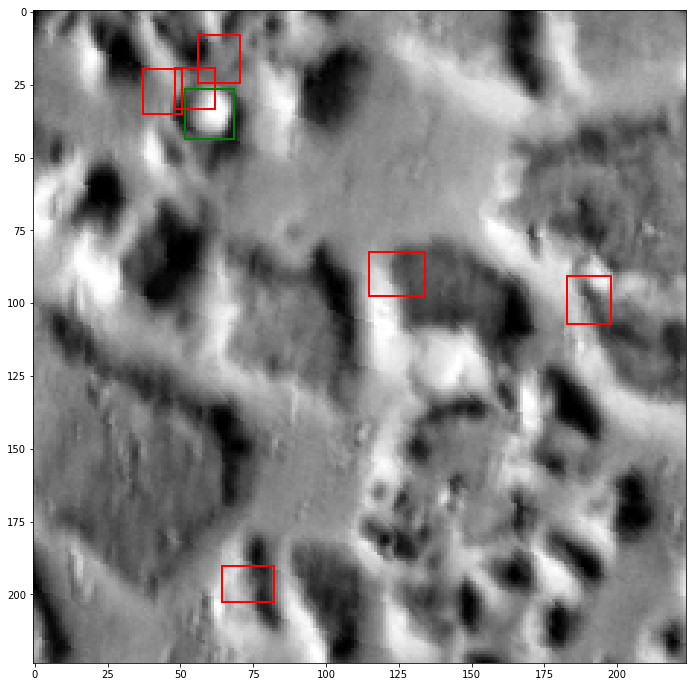

In [19]:
# 5: Draw the predicted boxes onto the image

fig, ax = plt.subplots(figsize=(20,12))
ax.imshow(X[0][:,:,0], cmap=plt.cm.gray)

classes = ['background', 'car', 'truck', 'pedestrian', 'bicyclist', 'light'] # Just so we can print class names onto the image instead of IDs

# Draw the predicted boxes in blue
#for box in np.sort(y_pred_decoded, axis=0)[-5:]:#[i]:
for box in y_pred_decoded:#[i]
    #label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    # current_axis.add_patch(plt.Rectangle((box[2], box[4]), box[3]-box[2], box[5]-box[4], color='blue', fill=False, linewidth=2))  
    #ax.add_patch(plt.Rectangle((box[4], box[2]), box[5]-box[4], box[3]-box[2], color='blue', fill=False, linewidth=2))  
    #current_axis.text(box[2], box[4], label, size='x-large', color='white', bbox={'facecolor':'blue', 'alpha':1.0})
    ax.add_patch(plt.Rectangle((box[2], box[4]), box[5]-box[4], box[3]-box[2], color='red', fill=False, linewidth=2))  

# Draw the ground truth boxes in green (omit the label for more clarity)
for box in y_true[i]:
    label = '{}'.format(classes[int(box[0])])
    ax.add_patch(plt.Rectangle((box[1], box[3]), box[2]-box[1], box[4]-box[3], color='green', fill=False, linewidth=2))  
    #current_axis.text(box[1], box[3], label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

In [201]:
img_i += 1
fig.savefig('pred{0}.png'.format(img_i))

In [71]:
img_i = 0

In [56]:
# 3: Make a prediction

y_pred = model.predict(X)

In [45]:
y_pred.shape

(1, 846, 14)

In [46]:
y_pred.max(axis=1)

array([[   0.95334971,    0.34092188,    0.73196298,    0.89551771,
           0.80067033,    0.93027145,  216.8661499 ,  216.8661499 ,
         143.36000061,  143.36000061,    1.        ,    1.        ,
           1.        ,    1.        ]], dtype=float32)

In [47]:
y_pred[0, :5, :]

array([[  8.75489414e-01,   1.24510586e-01,  -7.92782307e-02,
         -3.78759056e-02,  -1.63101763e-01,  -4.05734301e-01,
          6.63384628e+00,   6.63384628e+00,   1.32676926e+01,
          1.32676926e+01,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00],
       [  8.59737992e-01,   1.40262067e-01,  -1.03496417e-01,
          1.42429918e-02,  -3.04378510e-01,  -3.73497128e-01,
          1.29230766e+01,   6.63384628e+00,   1.79200001e+01,
          1.32676926e+01,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00],
       [  8.55269909e-01,   1.44730061e-01,  -1.58937097e-01,
         -8.65305811e-02,  -2.59914041e-01,  -2.76380807e-01,
          2.15384617e+01,   6.63384628e+00,   1.79200001e+01,
          1.32676926e+01,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00],
       [  8.41350377e-01,   1.58649594e-01,   2.92409882e-02,
         -6.61261678e-02,  -1.99257568e-01,  -2.33007193e-0

Now let's decode the raw prediction `y_pred`. The function `decode_y2()` converts the box coordinates from offsets back to absolute coordinates, keeps only the positive predictions (i.e. throws away all boxes for which the highest confidence is for class 0), applies a confidence threshold to all positive predictions, and applies non-maximum suppression to the remaining predictions, in this order. In case you would like to omit the NMS step, set `iou_threshold = None`.

You could also use `decode_y()`, which follows the prodecure outlined in the paper, to decode the raw predictions, but `decode_y2()` is more efficient and I found it yields better results. Check out the documentation for details on how the two decoders differ.

In [57]:
y_pred_decoded = decode_y(y_pred, confidence_thresh=0.3, input_coords='centroids')[0]

In [50]:
y_pred_decoded.shape

(3, 6)

In [35]:
# 4: Decode the raw prediction `y_pred`

y_pred_decoded = decode_y2(y_pred,
                           confidence_thresh=0.3,
                          iou_threshold=None,
                          top_k='all',
                          input_coords='centroids',
                          normalize_coords=False,
                          img_height=None,
                          img_width=None)

print("Decoded predictions (output format is [class_id, confidence, xmin, xmax, ymin, ymax]):\n")
print(y_pred_decoded[i])

Decoded predictions (output format is [class_id, confidence, xmin, xmax, ymin, ymax]):

[]


In [6]:
decode_y2??

Finally, let's draw the predicted boxes onto the image in blue to visualize the result. Each predicted box says its confidence next to the category name. The ground truth boxes are also drawn onto the image in green for comparison.

In [25]:
y_true

[array([[   1.  ,   70.9 ,   83.1 ,   28.9 ,   41.1 ],
        [   1.  ,   77.95,  134.05,   31.95,   88.05],
        [   1.  ,   58.05,  159.95,  108.05,  209.95]])]

In [26]:
y_pred_decoded

array([[   1.        ,    0.33272013,   73.54512787,   89.11553192,
         137.88822937,  147.87950134],
       [   1.        ,    0.33193931,   87.9737854 ,  109.26948547,
         136.97541809,  152.80717468],
       [   1.        ,    0.32662728,   62.3210144 ,   80.40657043,
         199.00117493,  211.44090271],
       [   1.        ,    0.32169396,   46.82630157,   63.33255768,
         171.10281372,  180.2588501 ],
       [   1.        ,    0.31990781,   61.91239166,   85.89624786,
          79.2433548 ,   92.42517853],
       [   1.        ,    0.31778255,   38.93367004,   55.1652298 ,
         135.50335693,  148.32440186],
       [   1.        ,    0.31590852,   62.70537567,   86.88904572,
          67.51211548,   83.28083801],
       [   1.        ,    0.31538633,   71.61753082,   90.9238205 ,
         206.73019409,  219.53860474],
       [   1.        ,    0.31477764,   53.41026688,   71.38562775,
         197.17619324,  207.71412659],
       [   1.        ,    0.31384009,

In [202]:
np.sort(y_pred_decoded, axis=0)[-5:]

array([[   1.        ,    0.30245382,  113.32232666,  123.53749084,
         181.00094604,  192.82168579],
       [   1.        ,    0.30501792,  134.70401001,  144.32858276,
         181.41238403,  193.28851318],
       [   1.        ,    0.30596915,  199.09143066,  209.09237671,
         205.9982605 ,  216.05722046],
       [   1.        ,    0.30804673,  205.27604675,  215.53424072,
         206.08206177,  216.90527344],
       [   1.        ,    0.30816913,  206.57415771,  217.77745056,
         214.61912537,  221.49198914]])

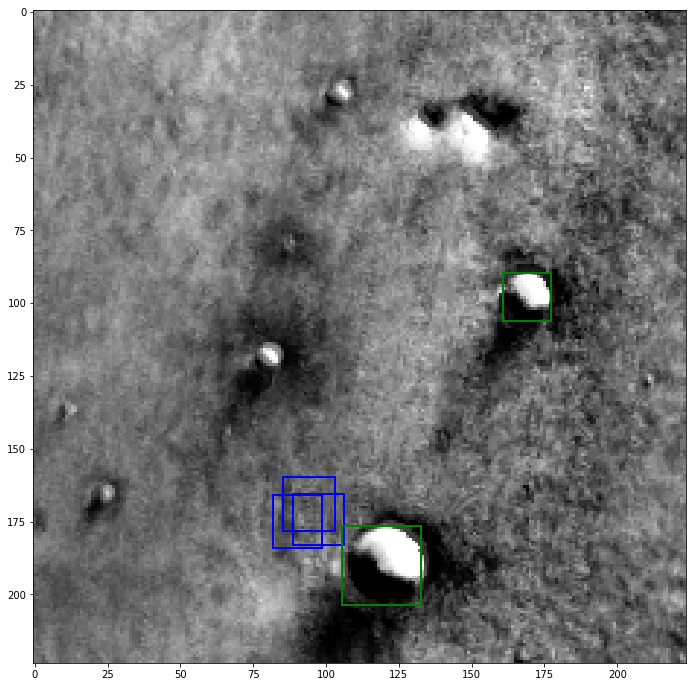

In [58]:
# 5: Draw the predicted boxes onto the image

plt.figure(figsize=(20,12))
plt.imshow(X[0][:,:,0], cmap=plt.cm.gray)

current_axis = plt.gca()

classes = ['background', 'car', 'truck', 'pedestrian', 'bicyclist', 'light'] # Just so we can print class names onto the image instead of IDs

# Draw the predicted boxes in blue
#for box in np.sort(y_pred_decoded, axis=0)[-5:]:#[i]:
for box in y_pred_decoded:#[i]
    #label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    # current_axis.add_patch(plt.Rectangle((box[2], box[4]), box[3]-box[2], box[5]-box[4], color='blue', fill=False, linewidth=2))  
    current_axis.add_patch(plt.Rectangle((box[4], box[2]), box[5]-box[4], box[3]-box[2], color='blue', fill=False, linewidth=2))  
    #current_axis.text(box[2], box[4], label, size='x-large', color='white', bbox={'facecolor':'blue', 'alpha':1.0})

# Draw the ground truth boxes in green (omit the label for more clarity)
for box in y_true[i]:
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((box[1], box[3]), box[2]-box[1], box[4]-box[3], color='green', fill=False, linewidth=2))  
    #current_axis.text(box[1], box[3], label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})